# Fully-Connected Autoencoder on MNIST

In [2]:
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from rgutils.plot_utils import plot_learning_curve, plot_image_pairs
from rgutils.torch_utils import autoencoder_output

%matplotlib inline

## MNIST

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Prepare Data

In [5]:
MNIST_DIR = './mnist_data/'
BATCH_SIZE = 64

In [6]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.45,), (0.2,)),
])

train_loader = DataLoader(datasets.MNIST(MNIST_DIR, train=True, download=False, 
                                         transform=mnist_transform),
                          batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(datasets.MNIST(MNIST_DIR, train=False, download=False,
                                       transform=mnist_transform),
                          batch_size=BATCH_SIZE, shuffle=True)

data_loaders = {
    'train': train_loader,
    'val': val_loader,
}

#### Define Network


In [7]:
input_width,input_height,input_channels = 28,28,1
reshaped_input = input_width * input_height * input_channels

In [90]:
class Autoencoder(nn.Module):
    '''
    A simple convnet
    '''
    def __init__(self,):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(reshaped_input, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, reshaped_input),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        x = x.view(-1, reshaped_input)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [91]:
net = Autoencoder().to(device)

print(net)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=100, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


#### Train and Evaluate

In [92]:
def train_autoencoder(num_epoch, model, dataloaders, input_size, optimizer, criterion, 
                      device, history=None, print_stats=True):
    '''
    Trains Autoencoder
    '''
    if history is not None:
        start_epoch = max(history['epoch']) + 1
        num_epoch = num_epoch + start_epoch
    else:
        history = {'epoch': [], 'train_score': [], 'val_score': [], 'train_loss': [], 'val_loss': []}
        start_epoch = 0
    for ep in range(start_epoch, num_epoch):
        if print_stats:
            print('='*10, 'Epoch', ep, '='*10)
        
        for step in ['train','val']:
            if step == 'train':
                model.train()
            else:
                model.eval()
    
            running_loss = 0
            for img_data,_ in dataloaders[step]:
                images = img_data.view(-1, *input_size).to(device)
                labels = img_data.view(-1, *input_size).to(device)

                y_pred = model(images)
                loss = criterion(y_pred, labels,)

                running_loss += loss.item() * labels.size(0)
                
                if step == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / len(dataloaders[step].dataset)
            history['{}_loss'.format(step)].append(epoch_loss)
        
        history['epoch'].append(ep)
        
        if print_stats:
            print('%7d Loss | Score' % ep)
            print('Train %.4f | %.1f' % (history['train_loss'][-1], 0))
            print('Valid %.4f | %.1f' % (history['val_loss'][-1], 0))
            print()
    return model, history

In [93]:
learning_rate = 0.1
num_epoch = 75
input_dims = (reshaped_input,)

In [94]:
optimizer = optim.SGD(net.parameters(), learning_rate)
criterion = nn.MSELoss()

In [95]:
model, history = train_autoencoder(num_epoch, net, data_loaders, input_dims, optimizer, criterion, device,
                                  history=history,
                                  )

========== Epoch 75 ==========
     75 Loss | Score
Train 5.0716 | 0.0
Valid 4.9289 | 0.0

========== Epoch 76 ==========
     76 Loss | Score
Train 4.9227 | 0.0
Valid 4.9279 | 0.0

========== Epoch 77 ==========
     77 Loss | Score
Train 4.9195 | 0.0
Valid 4.9243 | 0.0

========== Epoch 78 ==========
     78 Loss | Score
Train 4.9166 | 0.0
Valid 4.9198 | 0.0

========== Epoch 79 ==========
     79 Loss | Score
Train 4.9117 | 0.0
Valid 4.9130 | 0.0

========== Epoch 80 ==========
     80 Loss | Score
Train 4.8929 | 0.0
Valid 4.8782 | 0.0

========== Epoch 81 ==========
     81 Loss | Score
Train 4.8586 | 0.0
Valid 4.8521 | 0.0

========== Epoch 82 ==========
     82 Loss | Score
Train 4.8499 | 0.0
Valid 4.8481 | 0.0

========== Epoch 83 ==========
     83 Loss | Score
Train 4.8461 | 0.0
Valid 4.8455 | 0.0

========== Epoch 84 ==========
     84 Loss | Score
Train 4.8428 | 0.0
Valid 4.8413 | 0.0

========== Epoch 85 ==========
     85 Loss | Score
Train 4.8393 | 0.0
Valid 4.8386 | 0.0


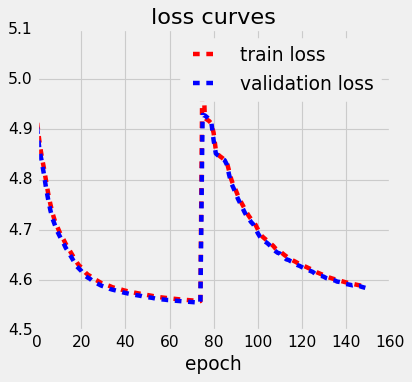

In [96]:
plot_learning_curve(history, metrics=['loss'], grid=(1,2), fig_shape=(10,5),)

##### Show images

In [101]:
N_SHOW = 10
SAVE_AS = 'hidden_512-256-100.png'

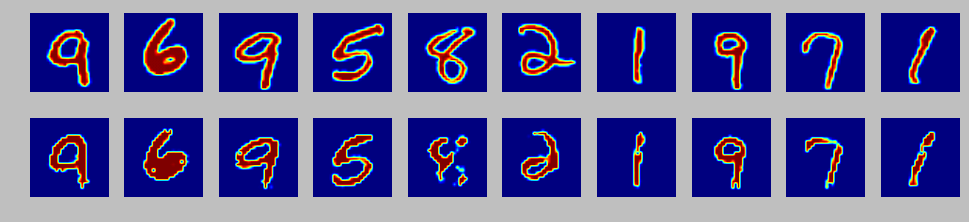

In [102]:
pairs = autoencoder_output(model, val_loader, num_show=N_SHOW, 
                         input_dim=(reshaped_input,), output_dim=(28,28),
                         device=device)

plot_image_pairs(pairs, (2,10), fig_shape=(15,3), style='classic', save_fig=SAVE_AS)

**Reporting**

Set params:
- SGD with learning rate at 0.1
- Means squared loss

|Hidden units|Epochs|Train loss|Val loss|
|---|---|---|---|
|100|75|4.663|4.661|
|256|50|4.601|4.598|
|[512,256]|75|4.557|4.554|
|[512,256,100]|75|4.587|4.584|